In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('imdb-5000-movie-dataset')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

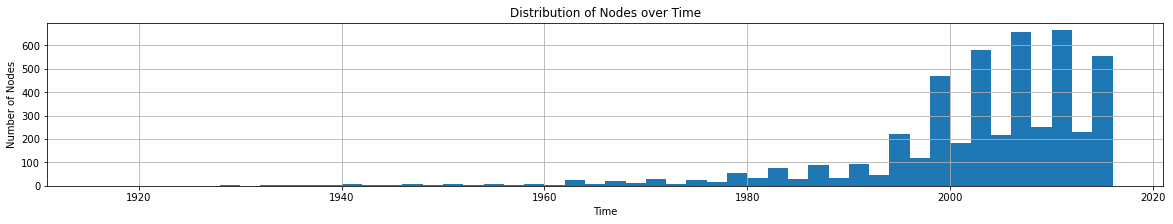

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 16614
Number of Edges: 52251
Density: 0.00018930946814506525


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 6.289996388587938
Median Degree: 3.0


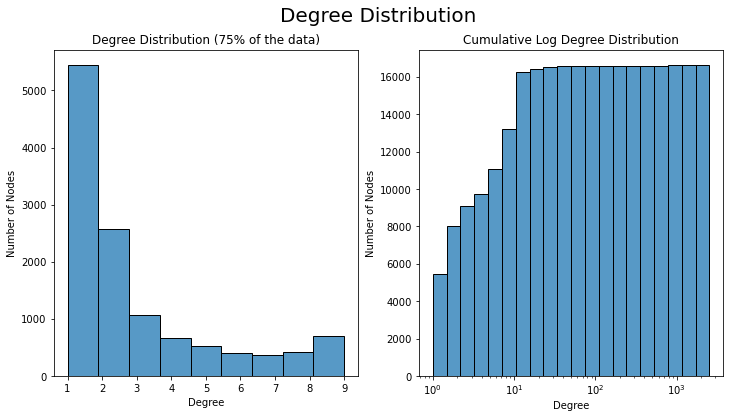

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,2535,Drama
1,1848,Comedy
2,1364,Thriller
3,1113,Action
4,1084,Romance
5,888,Adventure
6,869,Crime
7,595,Sci-Fi
8,583,Fantasy
9,540,Horror


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.0
Diameter: 6


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,16614.000000,16614.000000,16614.000000,11140.0
mean,0.000378,0.000229,0.000060,0.0
std,0.001980,0.010130,0.000259,0.0
min,0.000060,0.000000,0.000016,0.0
25%,0.000060,0.000000,0.000019,0.0
50%,0.000181,0.000000,0.000032,0.0
75%,0.000602,0.000057,0.000089,0.0
max,0.152591,1.000060,0.020398,0.0


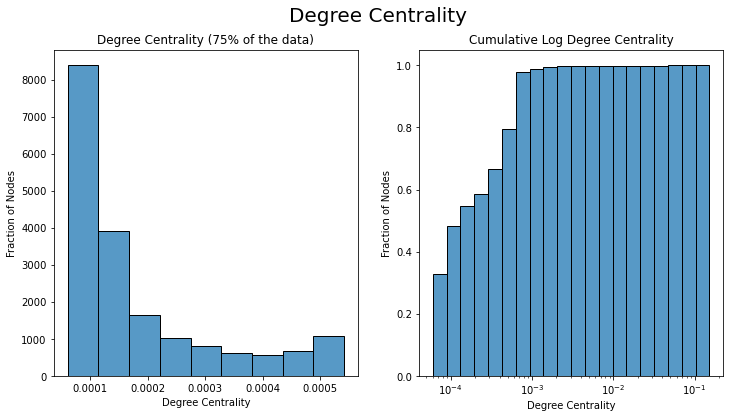

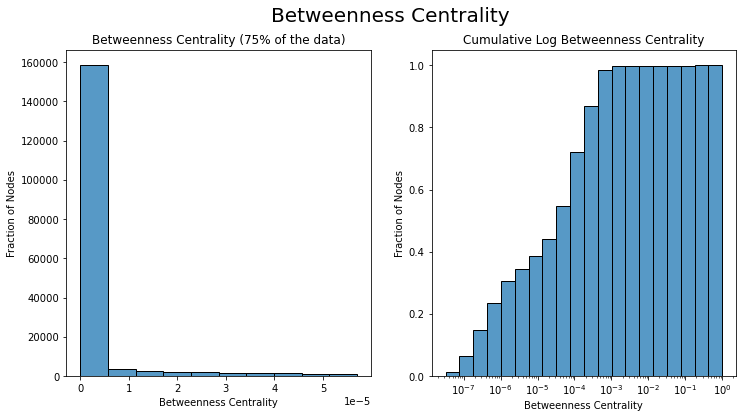

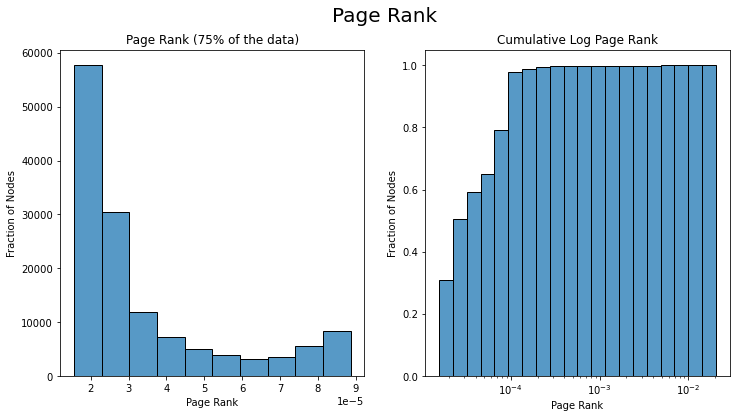

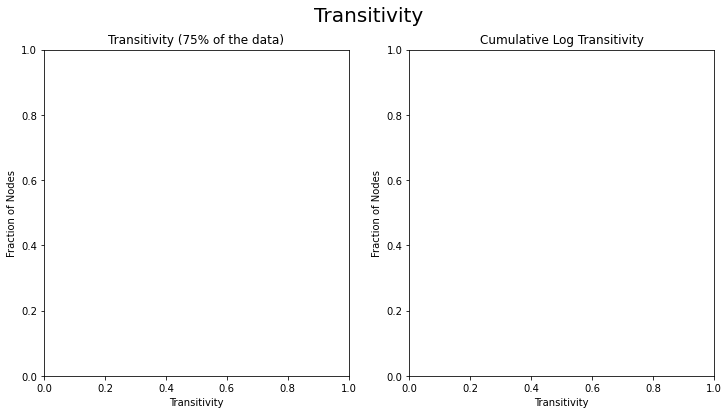

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,1.000060,House at the End of the Drive,0.020398,Drama,0.0,Intolerance: Love's Struggle Throughout the Ages
1,0.111238,Comedy,0.762043,Thriller,0.014613,Comedy,0.0,Harry Potter and the Half-Blood Prince
2,0.082104,Thriller,0.238874,Drama,0.010531,Thriller,0.0,female gunfighter
3,0.066996,Action,0.228237,Horror,0.008508,Romance,0.0,Becoming Jane
4,0.065250,Romance,0.100723,Comedy,0.008349,Action,0.0,Julian Jarrold
5,0.053452,Adventure,0.040882,Action,0.006652,Adventure,0.0,Must Love Dogs
6,0.052308,Crime,0.030848,Adventure,0.006593,Crime,0.0,Snakes on a Plane
7,0.035815,Sci-Fi,0.026800,Romance,0.004606,Horror,0.0,Bobb'e J. Thompson
8,0.035093,Fantasy,0.023717,Crime,0.004553,Sci-Fi,0.0,Idlewild
9,0.032505,Horror,0.018424,Fantasy,0.004413,Fantasy,0.0,playing piano


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 16614


Text(0.5, 1.0, 'Connected Components')

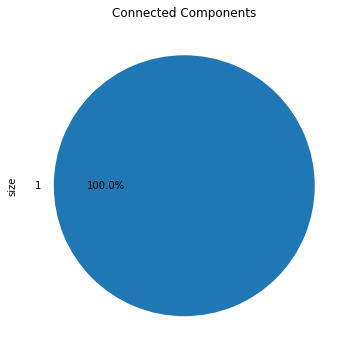

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 4


,type,count,degree_avg,degree_median
Genre,Genre,26,543.576923,265.5
Keyword,Keyword,3178,5.848332,3.0
Movie,Movie,4919,10.622281,11.0
Person,Person,8491,2.300318,1.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

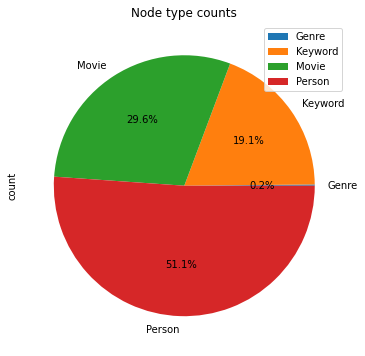

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

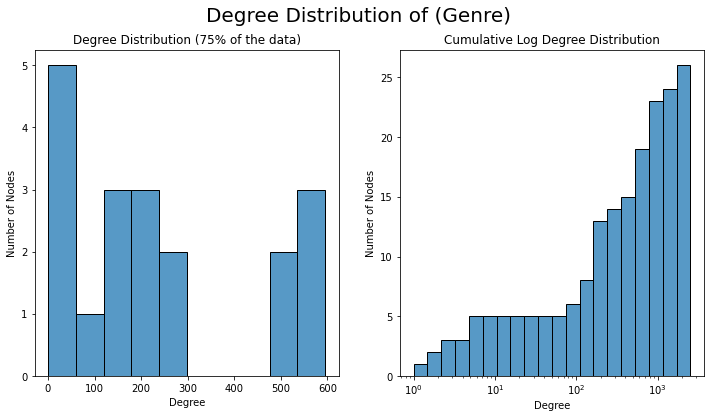

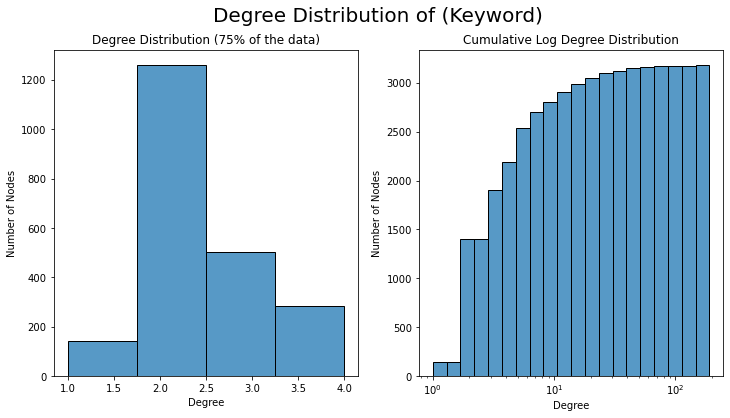

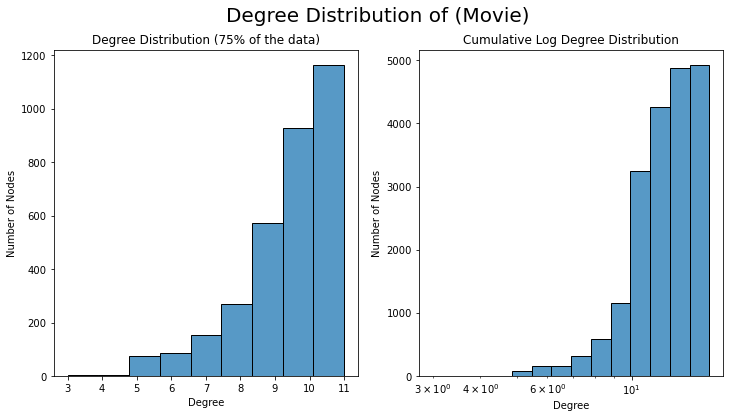

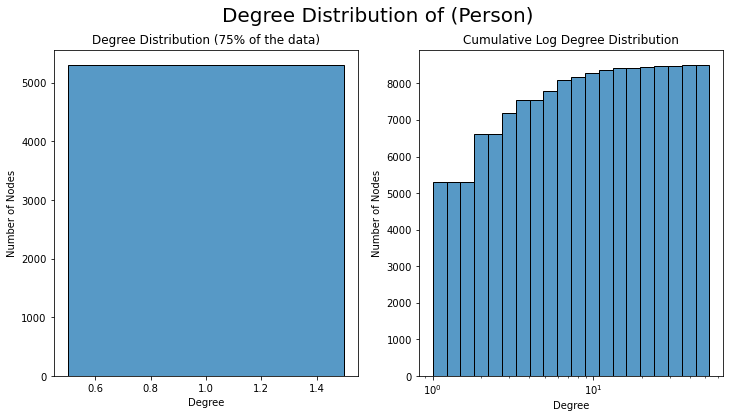

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Genre)


,value,label
0,2535,Drama
1,1848,Comedy
2,1364,Thriller
3,1113,Action
4,1084,Romance
5,888,Adventure
6,869,Crime
7,595,Sci-Fi
8,583,Fantasy
9,540,Horror


Top 10 Degree Nodes of Type (Keyword)


,value,label
0,191,love
1,164,friend
2,157,murder
3,129,death
4,125,police
5,91,new york city
6,88,high school
7,80,alien
8,71,boy
9,70,school


Top 10 Degree Nodes of Type (Movie)


,value,label
0,16,Alpha and Omega 4: The Legend of the Saw Tooth...
1,16,Reindeer Games
2,16,Lilo & Stitch
3,16,Big Hero 6
4,16,Tangled
5,16,The Prince of Egypt
6,16,TMNT
7,15,Teenage Mutant Ninja Turtles III
8,15,Anastasia
9,15,Dylan Dog: Dead of Night


Top 10 Degree Nodes of Type (Person)


,value,label
0,53,Robert De Niro
1,43,Morgan Freeman
2,38,Steve Buscemi
3,38,Bruce Willis
4,37,Matt Damon
5,36,Clint Eastwood
6,36,Johnny Depp
7,33,Brad Pitt
8,33,Woody Allen
9,33,Denzel Washington


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 4


,type,count
ACTED_IN,ACTED_IN,14715
DIRECTED,DIRECTED,4817
HAS_GENRE,HAS_GENRE,14133
HAS_KEYWORD,HAS_KEYWORD,18586


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

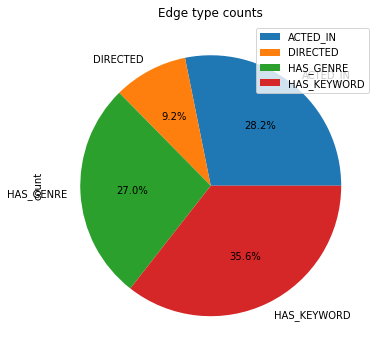

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Genre


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,0.762043,Thriller,0.020398,Drama,0.0,Thriller
1,0.111238,Comedy,0.238874,Drama,0.014613,Comedy,0.0,War
2,0.082104,Thriller,0.228237,Horror,0.010531,Thriller,0.0,Animation
3,0.066996,Action,0.100723,Comedy,0.008508,Romance,0.0,Drama
4,0.065250,Romance,0.040882,Action,0.008349,Action,0.0,Short
5,0.053452,Adventure,0.030848,Adventure,0.006652,Adventure,0.0,Comedy
6,0.052308,Crime,0.026800,Romance,0.006593,Crime,0.0,Mystery
7,0.035815,Sci-Fi,0.023717,Crime,0.004606,Horror,0.0,Film-Noir
8,0.035093,Fantasy,0.018424,Fantasy,0.004553,Sci-Fi,0.0,Horror
9,0.032505,Horror,0.015652,Sci-Fi,0.004413,Fantasy,0.0,Family


Top 10 Nodes by Statistic for Keyword


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.011497,love,0.007120,paranormal,0.001496,love,0.0,israel
1,0.009872,friend,0.001018,love,0.001267,friend,0.0,ring
2,0.009450,murder,0.000796,friend,0.001176,murder,0.0,suburb
3,0.007765,death,0.000742,murder,0.000972,death,0.0,barricade
4,0.007524,police,0.000651,police,0.000969,police,0.0,class
5,0.005478,new york city,0.000625,death,0.000703,new york city,0.0,cabin in the woods
6,0.005297,high school,0.000577,new york city,0.000698,high school,0.0,courthouse
7,0.004816,alien,0.000445,drugs,0.000601,alien,0.0,arab
8,0.004274,boy,0.000395,high school,0.000557,school,0.0,blind date
9,0.004214,school,0.000284,female protagonist,0.000550,boy,0.0,loan


Top 10 Nodes by Statistic for Movie


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000963,Tangled,1.000060,House at the End of the Drive,0.000215,Dekalog,0.0,Carnage
1,0.000963,Reindeer Games,0.003525,Man on Wire,0.000151,Alpha and Omega 4: The Legend of the Saw Tooth...,0.0,The Lone Ranger
2,0.000963,TMNT,0.003247,Crop Circles: Quest for Truth,0.000148,Man on Wire,0.0,Your Highness
3,0.000963,Alpha and Omega 4: The Legend of the Saw Tooth...,0.003057,Ghost Hunters,0.000148,The Prince of Egypt,0.0,This Is the End
4,0.000963,Big Hero 6,0.001885,Cheap Thrills,0.000146,The Return of the Living Dead,0.0,The November Man
5,0.000963,The Prince of Egypt,0.001868,BrainDead,0.000146,Airlift,0.0,Cargo
6,0.000963,Lilo & Stitch,0.001846,Some Guy Who Kills People,0.000145,Home,0.0,Unsullied
7,0.000903,The Iron Giant,0.001735,Alpha and Omega 4: The Legend of the Saw Tooth...,0.000145,Circle,0.0,Just Married
8,0.000903,The Rugrats Movie,0.001647,Dylan Dog: Dead of Night,0.000145,Metropolis,0.0,Our Idiot Brother
9,0.000903,In the Heart of the Sea,0.001509,Confessions of a Dangerous Mind,0.000144,Wicker Park,0.0,The Watcher


Top 10 Nodes by Statistic for Person


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003190,Robert De Niro,0.002299,Jessica Szohr,0.000385,Robert De Niro,0.0,Birgitte Hjort Sørensen
1,0.002588,Morgan Freeman,0.000191,Morgan Freeman,0.000314,Morgan Freeman,0.0,Claude Rains
2,0.002287,Bruce Willis,0.000125,Robert De Niro,0.000274,Matt Damon,0.0,Jessica Tandy
3,0.002227,Matt Damon,0.000115,Alfre Woodard,0.000271,Bruce Willis,0.0,Temuera Morrison
4,0.002227,Steve Buscemi,0.000094,Bill Murray,0.000270,Steve Buscemi,0.0,Zoë Bell
5,0.002167,Johnny Depp,0.000093,Clint Eastwood,0.000264,Johnny Depp,0.0,Henry Silva
6,0.001986,Nicolas Cage,0.000065,Matt Damon,0.000247,Will Ferrell,0.0,Kelsey Grammer
7,0.001986,Brad Pitt,0.000061,David Mamet,0.000244,Nicolas Cage,0.0,Ken Kwapis
8,0.001926,Bill Murray,0.000060,William Gazecki,0.000240,Brad Pitt,0.0,Cas Anvar
9,0.001926,Will Ferrell,0.000050,Steve Buscemi,0.000239,Liam Neeson,0.0,Ron Howard


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.4378052582358983
Number of communities: 82


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

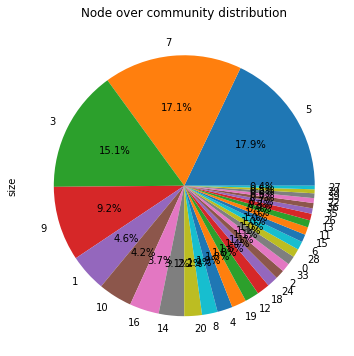

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000843,written and directed by cast member,0.000700,Coriolanus,0.000132,Inherent Vice,0.0,12 step program
1,0.000843,alcoholic,0.000260,Diamond Ruff,0.000130,Volver,0.0,Dead Man Walking
2,0.000843,Inherent Vice,0.000254,Volver,0.000122,written and directed by cast member,0.0,Johnson Family Vacation
3,0.000783,Volver,0.000236,Departure,0.000120,alcoholic,0.0,Being Julia
4,0.000722,ATL,0.000223,The Names of Love,0.000120,Departure,0.0,Bringing Down the House
5,0.000722,The Brothers McMullen,0.000221,The Four Seasons,0.000119,The Brothers McMullen,0.0,Hulk
6,0.000662,Tropic Thunder,0.000216,The Brothers McMullen,0.000118,ATL,0.0,L'auberge espagnole
7,0.000662,The Guilt Trip,0.000214,The Lost Weekend,0.000117,Diamond Ruff,0.0,Sweet November
8,0.000662,Rachel Getting Married,0.000211,Cries & Whispers,0.000116,The Lost Weekend,0.0,Whatever It Takes
9,0.000662,Nine,0.000206,ATL,0.000113,Nine,0.0,Magnolia


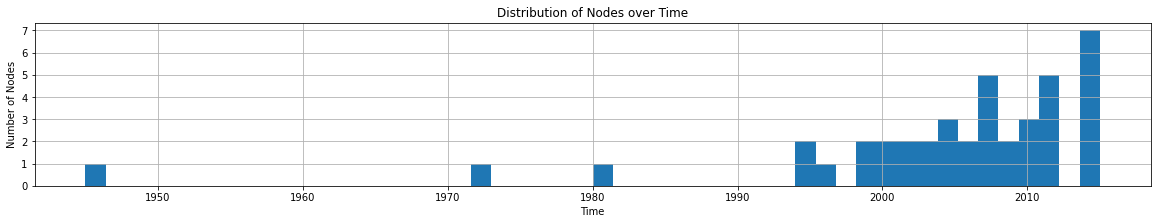

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.007283,Documentary,1.000060,House at the End of the Drive,0.001456,Documentary,0.0,12 year old
1,0.001926,family relationships,0.008557,Documentary,0.000265,family relationships,0.0,What Women Want
2,0.001445,three word title,0.007120,paranormal,0.000207,three word title,0.0,Civil Brand
3,0.000903,character name in title,0.003525,Man on Wire,0.000148,Man on Wire,0.0,Jackass: The Movie
4,0.000843,Man on Wire,0.003247,Crop Circles: Quest for Truth,0.000144,character name in title,0.0,House of Sand and Fog
5,0.000843,punctuation in title,0.003057,Ghost Hunters,0.000143,Book of Shadows: Blair Witch 2,0.0,The Blue Butterfly
6,0.000843,Book of Shadows: Blair Witch 2,0.002299,Jessica Szohr,0.000140,The Helix... Loaded,0.0,Bowling for Columbine
7,0.000783,Baby Boy,0.001249,Yoga Hosers,0.000140,The Red Violin,0.0,Scary Movie 3
8,0.000783,The Helix... Loaded,0.001129,Dragon Wars: D-War,0.000137,I Married a Strange Person!,0.0,Old School
9,0.000783,I Married a Strange Person!,0.000981,Book of Shadows: Blair Witch 2,0.000134,Burn,0.0,Winged Migration


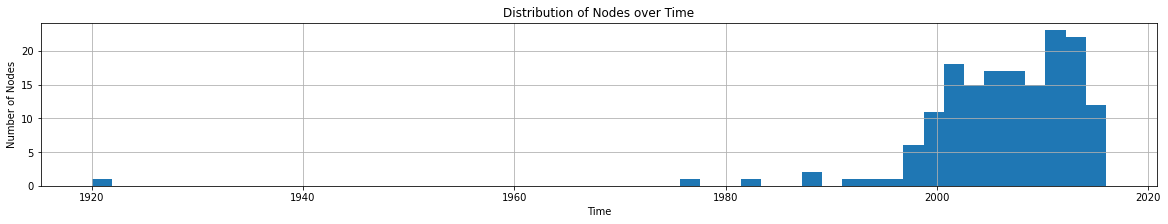

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000783,The Darkest Hour,0.001034,Amnesiac,0.000144,The Woman Chaser,0.0,14 year old
1,0.000783,The Great Escape,0.001009,The Host,0.000125,Amnesiac,0.0,The Great Escape
2,0.000722,Amnesiac,0.000836,The Darkest Hour,0.000125,Bran Nue Dae,0.0,Without a Paddle
3,0.000722,Kangaroo Jack,0.000812,Hobo with a Shotgun,0.000124,The Darkest Hour,0.0,Mondays in the Sun
4,0.000722,"The Good, the Bad, the Weird",0.000799,The Great Escape,0.000123,Out of the Blue,0.0,Time Changer
5,0.000722,Bran Nue Dae,0.000561,Spellbound,0.000122,The Reef,0.0,Bubble Boy
6,0.000662,The Reef,0.000545,Absentia,0.000121,The Grace Card,0.0,Kangaroo Jack
7,0.000662,river,0.000431,Into the Storm,0.000120,Hobo with a Shotgun,0.0,The Woman Chaser
8,0.000662,Warriors of Virtue,0.000374,Niagara,0.000120,God's Not Dead 2,0.0,Battlefield Earth
9,0.000662,Bubble Boy,0.000340,The Reef,0.000118,Spellbound,0.0,Driven


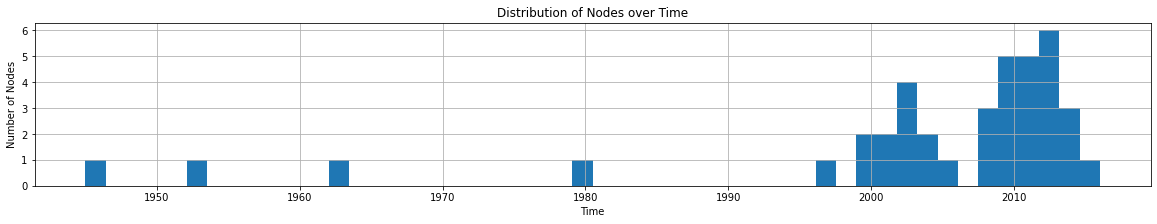

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.111238,Comedy,0.100723,Comedy,0.014613,Comedy,0.0,14th century
1,0.053452,Adventure,0.030848,Adventure,0.006652,Adventure,0.0,Recess: School's Out
2,0.035093,Fantasy,0.018424,Fantasy,0.004413,Fantasy,0.0,Black Knight
3,0.032144,Family,0.004147,Family,0.004128,Family,0.0,Megiddo: The Omega Code 2
4,0.014447,Animation,0.001735,Alpha and Omega 4: The Legend of the Saw Tooth...,0.001841,Animation,0.0,Digimon: The Movie
5,0.007885,Musical,0.001372,Goosebumps,0.001073,Musical,0.0,Ghost Rider
6,0.004816,alien,0.001361,Animation,0.000601,alien,0.0,Pootie Tang
7,0.004274,boy,0.001345,Wolf,0.000550,boy,0.0,Cursed
8,0.003311,dog,0.001327,Freddy's Dead: The Final Nightmare,0.000426,dog,0.0,About Schmidt
9,0.003250,island,0.001282,The Pacifier,0.000421,island,0.0,Scary Movie 2


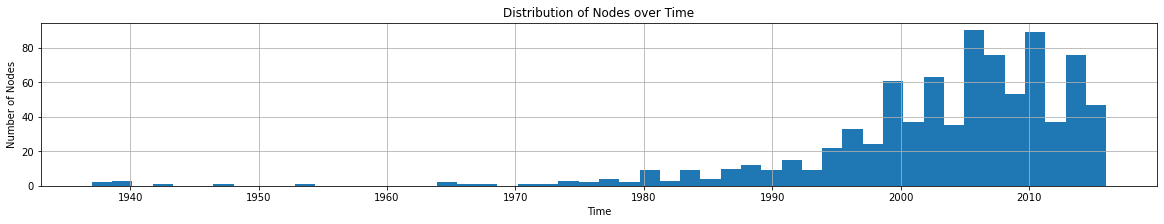

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.004214,school,0.001177,Fido,0.000557,school,0.0,15 year old
1,0.002468,teacher,0.001012,Roadside,0.000340,teacher,0.0,Dark Water
2,0.000783,Like Mike,0.000959,Dark Water,0.000134,Fido,0.0,Bringing Out the Dead
3,0.000783,Vessel,0.000860,Decoys,0.000133,Decoys,0.0,Drive Me Crazy
4,0.000783,Dear Wendy,0.000814,Dum Maaro Dum,0.000132,Vessel,0.0,Home Movies
5,0.000783,Roadside,0.000676,The Dirties,0.000130,The Hunt,0.0,The Business of Strangers
6,0.000783,Fido,0.000641,London to Brighton,0.000129,The Touch,0.0,Igby Goes Down
7,0.000783,Dum Maaro Dum,0.000625,Trust,0.000127,Ta Ra Rum Pum,0.0,The Emperor's Club
8,0.000722,Decoys,0.000609,The Return,0.000126,Osama,0.0,Rent
9,0.000722,Submarine,0.000592,Hayride,0.000125,Children of Heaven,0.0,Like Mike


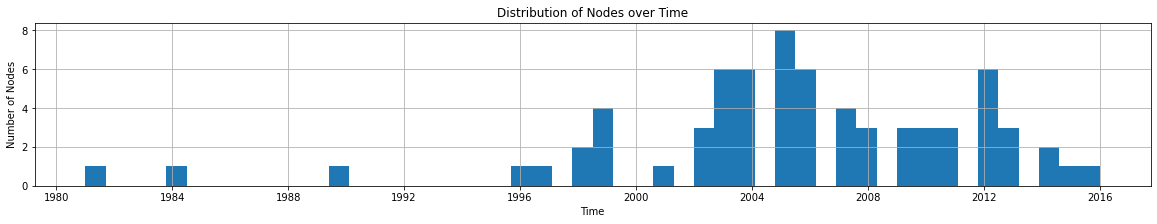

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,0.238874,Drama,0.020398,Drama,0.0,16th century
1,0.065250,Romance,0.026800,Romance,0.008508,Romance,0.0,The Hurricane
2,0.017516,Biography,0.003146,Biography,0.002299,Biography,0.0,Texas Rangers
3,0.012761,Music,0.001885,Cheap Thrills,0.001780,Music,0.0,Get Over It
4,0.012641,War,0.001883,War,0.001684,War,0.0,The Basket
5,0.012159,History,0.001850,Music,0.001618,History,0.0,Human Traffic
6,0.011497,love,0.001798,History,0.001496,love,0.0,The Patriot
7,0.010654,Sport,0.001487,The Hunting Party,0.001396,Sport,0.0,Down to You
8,0.009872,friend,0.001380,Mary Reilly,0.001267,friend,0.0,Jesus' Son
9,0.004033,friendship,0.001377,Harvard Man,0.000529,friendship,0.0,O


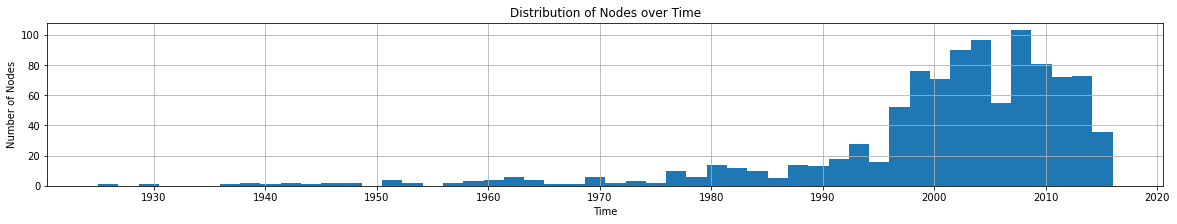

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.013454951038876254
Number of communities: 87


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

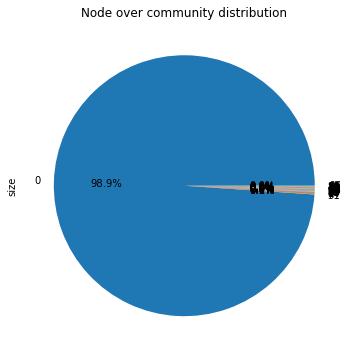

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.152591,Drama,1.000060,House at the End of the Drive,0.020398,Drama,0.0,12 step program
1,0.111238,Comedy,0.762043,Thriller,0.014613,Comedy,0.0,Waking Ned Devine
2,0.082104,Thriller,0.238874,Drama,0.010531,Thriller,0.0,Held Up
3,0.066996,Action,0.228237,Horror,0.008508,Romance,0.0,The Limey
4,0.065250,Romance,0.100723,Comedy,0.008349,Action,0.0,Romeo Must Die
5,0.053452,Adventure,0.040882,Action,0.006652,Adventure,0.0,Sinbad: Legend of the Seven Seas
6,0.052308,Crime,0.030848,Adventure,0.006593,Crime,0.0,The Doombolt Chase
7,0.035815,Sci-Fi,0.026800,Romance,0.004606,Horror,0.0,East Is East
8,0.035093,Fantasy,0.023717,Crime,0.004553,Sci-Fi,0.0,Foolish
9,0.032505,Horror,0.018424,Fantasy,0.004413,Fantasy,0.0,Monkeybone


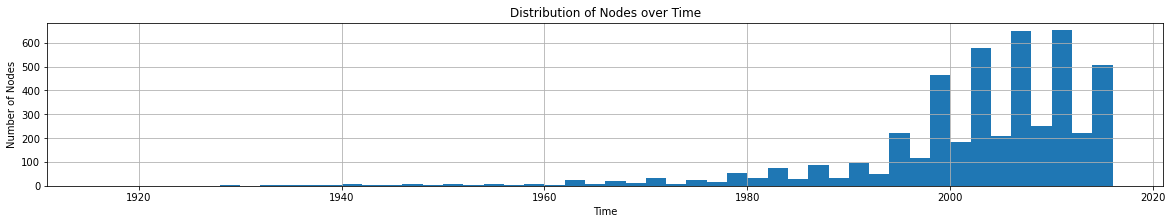

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000421,Queen Crab,0.000346,Queen Crab,0.000101,Fight Valley,0.0,Queen Crab
1,0.000361,Fight Valley,0.000241,Fight Valley,0.000100,Queen Crab,0.0,Fight Valley
2,0.000060,A.J. DeLucia,0.000000,A.J. DeLucia,0.000024,Cabrina Collesides,NaN,A.J. DeLucia
3,0.000060,Brett Piper,0.000000,Brett Piper,0.000024,Erin O'Brien,NaN,Brett Piper
4,0.000060,Cabrina Collesides,0.000000,Cabrina Collesides,0.000024,Kari J. Kramer,NaN,Cabrina Collesides
5,0.000060,Erin O'Brien,0.000000,Erin O'Brien,0.000024,Rob Hawk,NaN,Erin O'Brien
6,0.000060,Kari J. Kramer,0.000000,Kari J. Kramer,0.000021,A.J. DeLucia,NaN,Kari J. Kramer
7,0.000060,Michelle Simone Miller,0.000000,Michelle Simone Miller,0.000021,Brett Piper,NaN,Michelle Simone Miller
8,0.000060,Rob Hawk,0.000000,Rob Hawk,0.000021,Michelle Simone Miller,NaN,Rob Hawk
9,0.000060,Steve Diasparra,0.000000,Steve Diasparra,0.000021,Steve Diasparra,NaN,Steve Diasparra


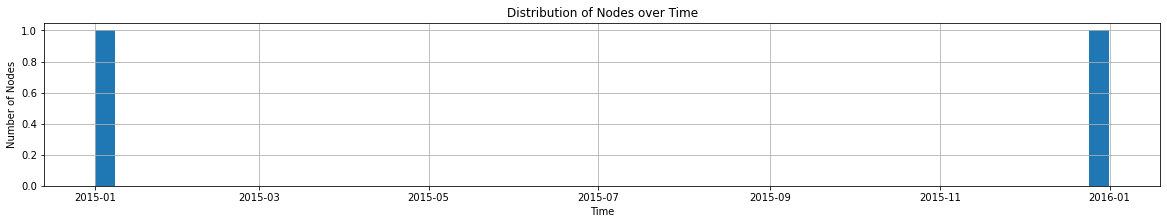

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000421,Guiana 1838,0.000253,Guiana 1838,0.000109,Guiana 1838,0.0,Guiana 1838
1,0.000060,Aasheekaa Bathija,0.000000,Aasheekaa Bathija,0.000022,Aasheekaa Bathija,NaN,Aasheekaa Bathija
2,0.000060,Kumar Gaurav,0.000000,Kumar Gaurav,0.000022,Kumar Gaurav,NaN,Kumar Gaurav
3,0.000060,Rohit Jagessar,0.000000,Rohit Jagessar,0.000022,Rohit Jagessar,NaN,Rohit Jagessar
4,0.000060,Rufus Graham,0.000000,Rufus Graham,0.000022,Rufus Graham,NaN,Rufus Graham


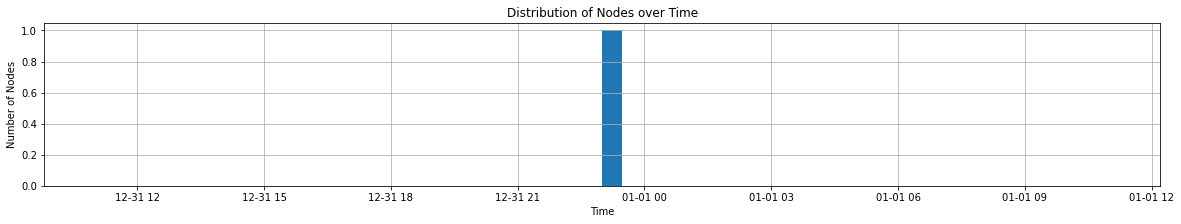

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000301,Butterfly Girl,0.000241,Butterfly Girl,0.000118,Butterfly Girl,0.0,Butterfly Girl
1,0.000060,Abigail Evans,0.000000,Abigail Evans,0.000029,Abigail Evans,NaN,Abigail Evans
2,0.000060,Cary Bell,0.000000,Cary Bell,0.000029,Cary Bell,NaN,Cary Bell
3,0.000060,Emily Gorell,0.000000,Emily Gorell,0.000029,Emily Gorell,NaN,Emily Gorell
4,0.000060,Stacie Evans,0.000000,Stacie Evans,0.000029,Stacie Evans,NaN,Stacie Evans


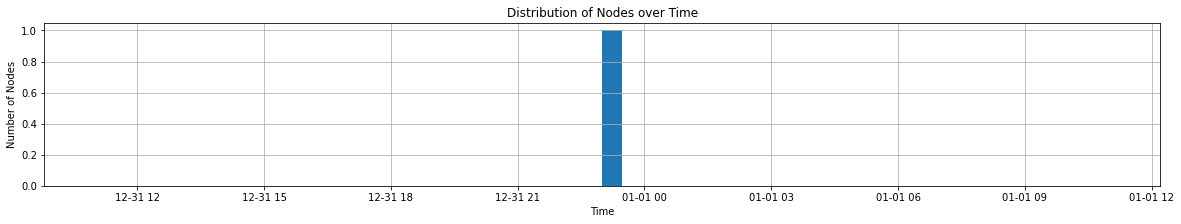

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000301,The Dog Lover,0.000181,The Dog Lover,0.000083,The Dog Lover,0.0,The Dog Lover
1,0.000060,Alex Ranarivelo,0.000000,Alex Ranarivelo,0.000023,Alex Ranarivelo,NaN,Alex Ranarivelo
2,0.000060,Christina Moore,0.000000,Christina Moore,0.000023,Christina Moore,NaN,Christina Moore
3,0.000060,Cullen Douglas,0.000000,Cullen Douglas,0.000023,Cullen Douglas,NaN,Cullen Douglas


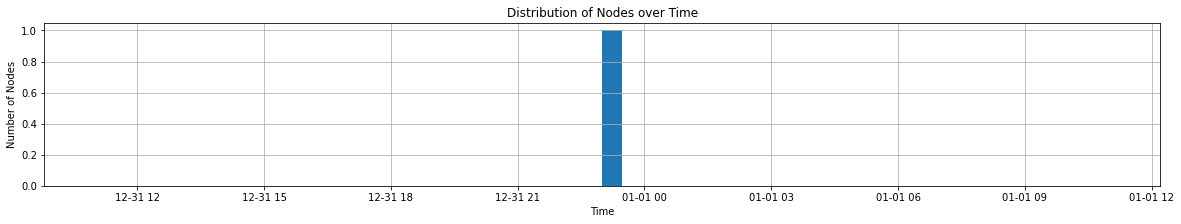

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000301,10 Days in a Madhouse,0.000181,10 Days in a Madhouse,0.000082,10 Days in a Madhouse,0.0,10 Days in a Madhouse
1,0.000060,Alexandra Callas,0.000000,Alexandra Callas,0.000023,Alexandra Callas,NaN,Alexandra Callas
2,0.000060,Kelly LeBrock,0.000000,Kelly LeBrock,0.000023,Kelly LeBrock,NaN,Kelly LeBrock
3,0.000060,Timothy Hines,0.000000,Timothy Hines,0.000023,Timothy Hines,NaN,Timothy Hines


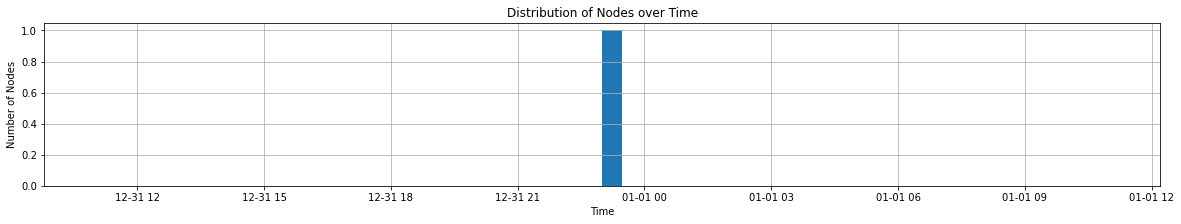

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')